In this notebook we train the rtrbm on complex artificial data of 9 populations:

population 1: no correlation, random spiking

population 2 - 9: high inter-neuron correlation (0.9)

population 2: no correlation to other populations

population 3 - 9: these populations are spatially correlated (.5, .5, .8, .8, .8, .8, .8)

population 5 - 9: have additional time shifted spikes, which makes them temporally correlated

In [1]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

# spikes, behavior, coordinates, df, stimulus = loaddata()

"""
to dump:

path = os.path.dirname(os.getcwd())
pickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))

to load:

check1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))
"""

"\nto dump:\n\npath = os.path.dirname(os.getcwd())\npickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))\n\nto load:\n\ncheck1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))\n"

In [2]:
data, coordinates, pop_idx = create_complex_artificial_data(t_max=5000)

Text(0.5, 1.0, 'mean firing rates of each neuron sorted by population')

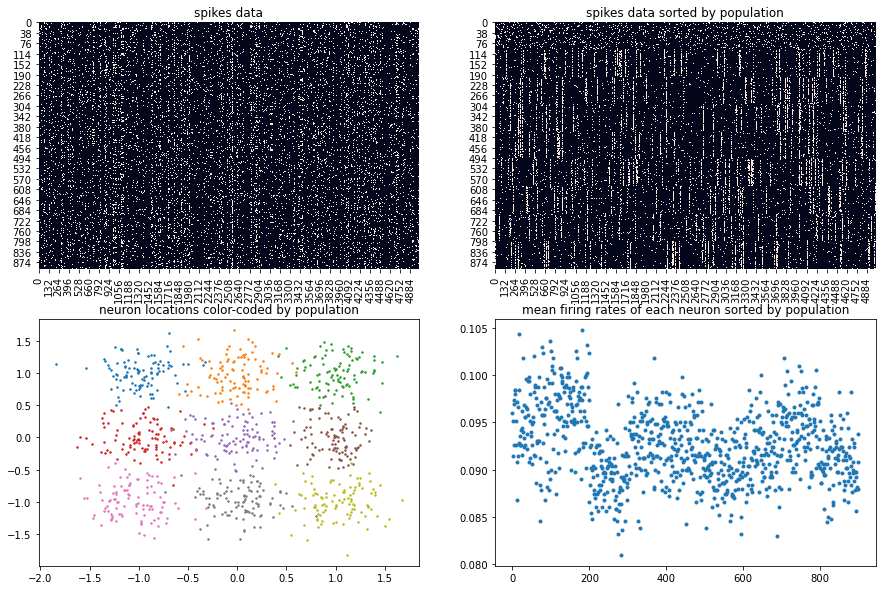

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.heatmap(data, ax=ax[0, 0], cbar=False)
ax[0, 0].set_title('spikes data')
sns.heatmap(data[pop_idx.flatten()], ax=ax[0, 1], cbar=False)
ax[0, 1].set_title('spikes data sorted by population')
for i in range(pop_idx.shape[0]):
    ax[1, 0].plot(coordinates[pop_idx[i], 0], coordinates[pop_idx[i], 1], '.', ms=3)
ax[1, 0].set_title('neuron locations color-coded by population')
ax[1, 1].plot(np.mean(data[pop_idx.flatten()], axis=1), '.')
ax[1, 1].set_title('mean firing rates of each neuron sorted by population')

In [4]:
#train_data, test_data = generate_train_test(torch.tensor(data), train_data_ratio=.7)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:41<00:00,  2.07s/it]


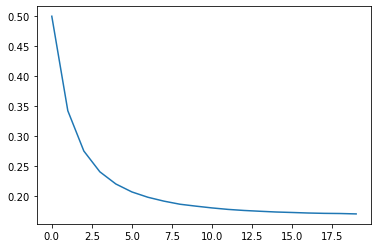

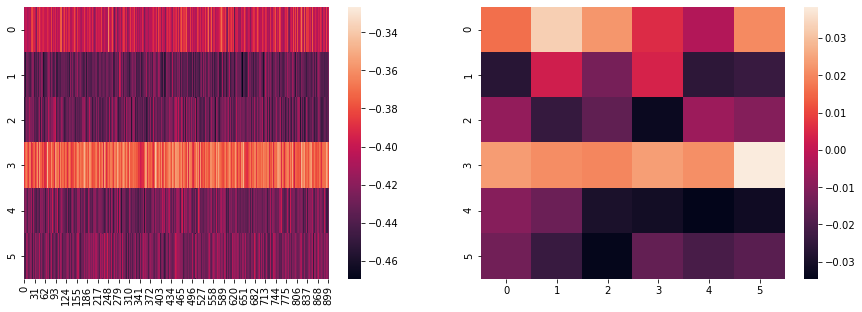

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ValueError: need at least one array to concatenate

<Figure size 864x648 with 1 Axes>

In [10]:
rtrbm = RTRBM(torch.tensor(data), N_H=6, device="cpu")
rtrbm.learn(n_epochs=20, batchsize=1, CDk=5, PCD=False, lr=5e-4, sp=None, mom=0, wc=0)

#pickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\complex_artificial_data_500epo_6_hiddens', 'wb'))

plt.plot(rtrbm.errors)

fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.heatmap(rtrbm.W, ax=ax[0])
sns.heatmap(rtrbm.W_acc, ax=ax[1])

VH = rtrbm.W.clone()
VH[VH<0] = 0

rf = get_hidden_mean_receptive_fields(VH, coordinates)
create_plot(VH, rtrbm.W_acc.cpu(), rf, torch.tensor(coordinates), 0, hiddens_radius=.1, weight_line_factor=0.1, hidden_weight_thresh=1)

In [12]:
rtrbm.learn(n_epochs=50, batchsize=1, CDk=5, PCD=False, lr=1e-4, sp=None, mom=0, wc=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:43<00:00,  2.06s/it]


<AxesSubplot:>

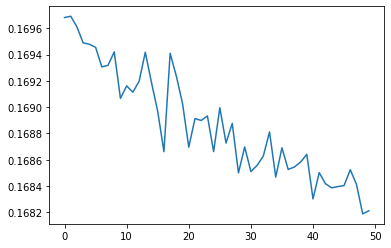

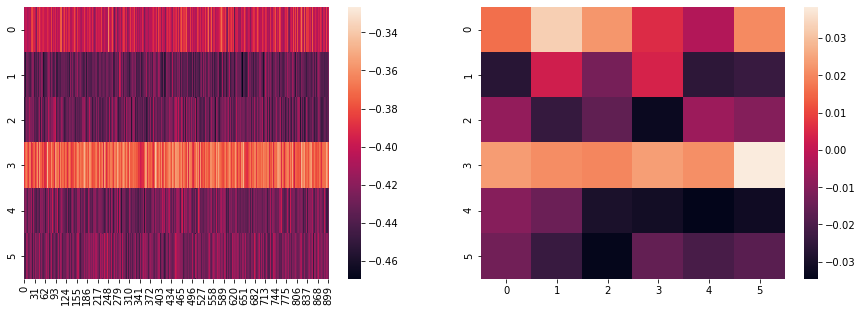

In [13]:
plt.plot(rtrbm.errors)

fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.heatmap(rtrbm.W, ax=ax[0])
sns.heatmap(rtrbm.W_acc, ax=ax[1])


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [19:54<00:00,  2.39s/it]


<AxesSubplot:>

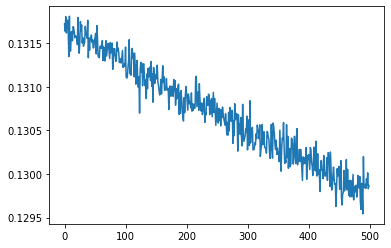

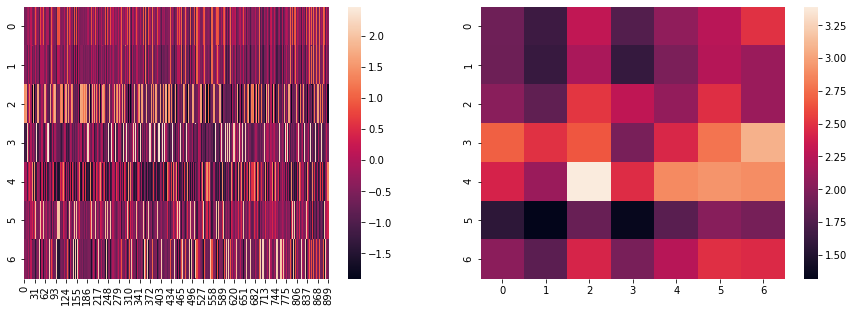

In [18]:
rtrbm.learn(n_epochs=500, batchsize=1, CDk=5, PCD=False, lr=1e-5, sp=None, mom=0, wc=0)

pickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\complex_artificial_data_1000epo_7_hiddens', 'wb'))

plt.plot(rtrbm.errors)

fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.heatmap(rtrbm.W, ax=ax[0])
sns.heatmap(rtrbm.W_acc, ax=ax[1])


In [5]:
import numpy as np
from math import cos, sin, atan2
from palettable.tableau import Tableau_10, Tableau_20
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, RegularPolygon
from numpy import radians as rad
import torch


def draw_neuron(x, y, neuron_radius, id=-1):
    # circle = plt.Circle((x, y), radius=neuron_radius, fill=False, color=Tableau_20.mpl_colors[2*id])
    # plt.gca().add_patch(circle)
    # plt.gca().text(x, y-(neuron_radius/4), str(id), size=neuron_radius*1000, ha='center')

    circle = plt.Circle((x, y), radius=neuron_radius, fill=False, color=Tableau_20.mpl_colors[2 * id])
    plt.gca().add_patch(circle)
    plt.gca().text(x + neuron_radius, y + neuron_radius, str(id), size=neuron_radius * 1000, ha='center', fontsize=20)


def line_between_two_neurons(neuron1_x, neuron1_y, neuron2_x, neuron2_y, neuron_radius, weight=0.4,
                             weight_line_factor=1):
    angle = atan2(neuron2_x - neuron1_x, neuron2_y - neuron1_y)
    x_adjustment = neuron_radius * sin(angle)
    y_adjustment = neuron_radius * cos(angle)

    # assign colors to lines depending on the sign of the weight
    color = Tableau_10.mpl_colors[3]
    if weight > 0: color = Tableau_10.mpl_colors[2]

    # assign different linewidths to lines depending on the size of the weight
    abs_weight = abs(weight)
    linewidth = 2 * abs_weight * weight_line_factor

    # draw self-connecting arrow
    if neuron1_x == neuron2_x:
        drawCirc(plt.gca(), neuron_radius * 2, neuron1_x, neuron1_y, -30, 230, color_=color, lw=3 * linewidth)

    # draw arrow   
    else:
        plt.gca().arrow(neuron1_x + x_adjustment, neuron1_y + y_adjustment,
                        neuron2_x - neuron1_x - 2 * x_adjustment, neuron2_y - neuron1_y - 2 * y_adjustment,
                        lw=3 * linewidth, color=color, length_includes_head=True, overhang=0)

        #style = "Simple, tail_width=0.5, head_width=4, head_length=8"
        #kw = dict(arrowstyle=style, color="k")

       # a1 = patches.FancyArrowPatch((float(neuron1_x + x_adjustment), float(neuron1_y + y_adjustment)),  # from
       #                              (float(neuron2_x - neuron1_x - 2 * x_adjustment),
       #                               float(neuron2_y - neuron1_y - 2 * y_adjustment)),  # to
       #                              **kw, connectionstyle="arc3, rad=0.2")

        #plt.gca().add_patch(a1)
    # plt.gca().add_line(line)


def drawCirc(ax, radius, centX, centY, angle_, theta2_, color_='black', lw=1):
    # ========Line
    if lw > 0.1:
        arc = Arc([centX, centY + radius / 2], radius, radius, angle=angle_,
                  theta1=0, theta2=theta2_, capstyle='round', linestyle='-', lw=lw, color=color_)
        ax.add_patch(arc)

        # ========Create the arrow head
        endX = centX + (radius / 2) * np.cos(rad(theta2_ + angle_))  # Do trig to determine end position
        endY = centY + (radius / 2) * np.sin(rad(theta2_ + angle_))

        ax.add_patch(  # Create triangle as arrow head
            RegularPolygon(
                (endX, endY + radius / 2),  # (x,y)
                3,  # number of vertices
                radius / 9,  # radius
                rad(angle_ + theta2_),  # orientation
                color=color_
            )
        )
    # ax.set_xlim([centX-radius,centY+radius]) and ax.set_ylim([centY-radius,centY+radius])
    # Make sure you keep the axes scaled or else arrow will distort


def plot_VH_connections(ax, VH, coordinates, strong_thresh=0.5, markersize=2):
    N_H, N_V = VH.shape
    max_hidden_connection = torch.max(VH, 0)[1]

    for h in range(N_H):
        ax.scatter(coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) > strong_thresh), 0],
                   coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) > strong_thresh), 1],
                   color=Tableau_20.mpl_colors[(2 * h) % 20], s=markersize)

        ax.scatter(coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) < strong_thresh), 0],
                   coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) < strong_thresh), 1],
                   color=Tableau_20.mpl_colors[(2 * h + 1) % 20], s=markersize)


def create_plot(VH, HH, rf, coords, dy, dx=0, markersize_visibles=20, hiddens_radius=0.02, weight_line_factor=1, hidden_weight_thresh=0):
    plt.figure(figsize=(12, 9))
    x_hidden_mean_receptive_fields = rf[:, 0]
    y_hidden_mean_receptive_fields = rf[:, 1]
    N_H = HH.shape[0]

    for h in range(N_H):
        draw_neuron(x_hidden_mean_receptive_fields[h], y_hidden_mean_receptive_fields[h], hiddens_radius, id=h)

    for h in range(N_H):
        for hh in range(N_H):
            if abs(HH[h, hh]) > hidden_weight_thresh:
                if h < hh:
                    dy = -dy
                    dx = -dx
                    line_between_two_neurons(x_hidden_mean_receptive_fields[h]+dx, y_hidden_mean_receptive_fields[h] + dy,
                                             x_hidden_mean_receptive_fields[hh]+dx, y_hidden_mean_receptive_fields[hh] + dy,
                                             hiddens_radius, weight=HH[h, hh], weight_line_factor=weight_line_factor)
                else:
                    dy = abs(dy)
                    dx = abs(dx)
                    line_between_two_neurons(x_hidden_mean_receptive_fields[h]+dx, y_hidden_mean_receptive_fields[h] + dy,
                                             x_hidden_mean_receptive_fields[hh]+dx, y_hidden_mean_receptive_fields[hh] + dy,
                                             hiddens_radius, weight=HH[h, hh], weight_line_factor=weight_line_factor)

    plot_VH_connections(plt.gca(), VH, coords, markersize=markersize_visibles)

    plt.gca().set_xlim(torch.min(coords[:, 0]), torch.max(coords[:, 0]))
    plt.gca().set_ylim(torch.min(coords[:, 1]), torch.max(coords[:, 1]))

    plt.plot(coords[:, 0], coords[:, 1], 'g.', markersize=1, zorder=-10)
    plt.show()
